#  Titanic Survival Prediction – End-to-End ML Pipeline

This notebook presents a complete machine learning workflow for predicting survival outcomes on the Titanic dataset.  
It includes data preprocessing, feature engineering, model training, evaluation, and optimization.

---

## Step 1: Import Required Libraries

We start by importing essential libraries for:

- **Data manipulation**: `pandas`, `numpy`
- **Data visualization**: `matplotlib`, `seaborn`
- **Machine learning models**: Logistic Regression, Random Forest, Support Vector Machine (SVM)
- **Model selection & evaluation**: Cross-validation, Grid Search, classification metrics


In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV,
)

from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

##  Step 2: Load the Dataset

We load the Titanic training dataset (`train.csv`) into a pandas DataFrame for exploration and preprocessing.

The dataset contains information about passengers including age, class, sex, fare, family relations, and whether they survived the disaster.


In [56]:
df = pd.read_csv("train.csv")

In [57]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


##  Step 3: Data Cleaning

- **Dropped Columns**: Removed `Cabin`, `Ticket`, and `PassengerId` since they are either irrelevant or contain too many missing values.
- **Age Imputation**: Filled missing `Age` values using the **median age within each `Pclass` group**, assuming similar socioeconomic status among passengers of the same class.
- **Embarked Imputation**: Filled missing values in the `Embarked` column with the most frequent port (`mode`), which is a common and safe strategy.


In [58]:
df.drop(['Cabin','Ticket', 'PassengerId'], axis =1, inplace =True)

df['Age']  = df.groupby("Pclass")["Age"].transform(lambda x : x.fillna(x.median()))

df["Embarked"].fillna(df["Embarked"].mode()[0], inplace =True )

C:\Users\chour\AppData\Local\Temp\ipykernel_7244\2027348851.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Embarked"].fillna(df["Embarked"].mode()[0], inplace =True )


##  Step 4: Feature Engineering

- **Title Extraction**: Extracted titles (e.g., Mr, Miss, Dr) from passenger names, which can reflect social status and potentially survival chances.
- **Rare Title Grouping**: Combined uncommon titles under the label `Rare` and standardized others like `Mlle → Miss`, `Mme → Mrs`.
- **Family Size**: Created a new feature combining `SibSp` and `Parch`, representing the total family size aboard.
- **IsAlone**: A binary feature indicating whether the passenger was traveling alone (`1`) or with family (`0`).
- **AgeGroup**: Converted continuous `Age` into categorical bins like `Child`, `Teen`, `Adult`, and `Senior` to capture age-based patterns.


In [59]:
# Title from Name
df["Title"] = df['Name'].str.extract(' ([A-Za-z]+)\\.', expand =True )

# Group rare titles
rare_titles = ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona']
df['Title'] = df['Title'].replace(rare_titles, "Rare")
df['Title'] = df['Title'].replace( {
    'Mlle' : 'Miss',
    'Ms' : 'Miss',
    'Mme' : 'Mrs'})

# Family Size and IsAlone
df['FamilySize'] = df["SibSp"] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
 
df['AgeGroup'] = pd.cut(df['Age'], bins= [0,12,18,60,100] , labels=['Child', 'Teen', 'Adult', 'Senior'])

In [60]:
df.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone,AgeGroup
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr,2,0,Adult
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs,2,0,Adult


##  Step 5: Encoding Categorical Variables

To prepare the dataset for machine learning algorithms, we convert categorical text features into numeric format:

- **Label Encoding (`Sex`)**: Transforms the binary gender feature (`male`, `female`) into numeric values (`1`, `0`).
- **One-Hot Encoding (`Embarked`, `Title`, `AgeGroup`)**:
  - Creates separate binary columns for each category in these features.
  - `drop_first=True` is used to avoid the dummy variable trap and reduce multicollinearity.


In [61]:

le = LabelEncoder()
df['Sex_encoded'] = le.fit_transform(df['Sex'])

# One-hot encoding for Embarked, Title, AgeGroup
df = pd.get_dummies(df, columns=['Embarked', 'Title', 'AgeGroup'] , drop_first =True )

In [62]:
df.head(710)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Sex_encoded,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,AgeGroup_Teen,AgeGroup_Adult,AgeGroup_Senior
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,2,0,1,False,True,False,True,False,False,False,True,False
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,2,0,0,False,False,False,False,True,False,False,True,False
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,1,1,0,False,True,True,False,False,False,False,True,False
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,2,0,0,False,True,False,False,True,False,False,True,False
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,1,1,1,False,True,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,0,2,"Morley, Mr. Henry Samuel (""Mr Henry Marshall"")",male,39.0,0,0,26.0000,1,1,1,False,True,False,True,False,False,False,True,False
706,1,2,"Kelly, Mrs. Florence ""Fannie""",female,45.0,0,0,13.5000,1,1,0,False,True,False,False,True,False,False,True,False
707,1,1,"Calderhead, Mr. Edward Pennington",male,42.0,0,0,26.2875,1,1,1,False,True,False,True,False,False,False,True,False
708,1,1,"Cleaver, Miss. Alice",female,22.0,0,0,151.5500,1,1,0,False,True,True,False,False,False,False,True,False


##  Step 6: Define Features, Target & Split the Dataset

- **`X` (Features)**: All relevant input variables used for prediction, excluding:
  - `Survived` (our target)
  - `Name` (not predictive)
  - `Sex` (we already encoded it as `Sex_encoded`)
  
- **`y` (Target)**: The column `Survived`, which we want to predict (binary classification).

- **Train-Test Split**:
  - 80% of the data is used for training the model.
  - 20% is reserved for evaluating performance on unseen data.
  - `random_state=42` ensures reproducibility of results.


In [63]:
X = df.drop(['Survived', 'Name', 'Sex'], axis=1)
y = df['Survived']

# Split into train/text
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size =0.2,random_state = 42
)

In [64]:
X_test

,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Sex_encoded,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,AgeGroup_Teen,AgeGroup_Adult,AgeGroup_Senior
709,3,24.0,1,1,15.2458,3,0,1,False,False,False,False,False,False,False,True,False
439,2,31.0,0,0,10.5000,1,1,1,False,True,False,True,False,False,False,True,False
840,3,20.0,0,0,7.9250,1,1,1,False,True,False,True,False,False,False,True,False
720,2,6.0,0,1,33.0000,2,0,0,False,True,True,False,False,False,False,False,False
39,3,14.0,1,0,11.2417,2,0,0,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,3,17.0,0,0,7.1250,1,1,1,False,True,False,True,False,False,True,False,False
773,3,24.0,0,0,7.2250,1,1,1,False,False,False,True,False,False,False,True,False
25,3,38.0,1,5,31.3875,7,0,0,False,True,False,False,True,False,False,True,False
84,2,17.0,0,0,10.5000,1,1,0,False,True,True,False,False,False,True,False,False


##  Step 7: Train the Model & Make Predictions

- We initialize a **Random Forest Classifier**, an ensemble model that uses multiple decision trees to make robust predictions.
- The model is trained on the **training set (`X_train`, `y_train`)** using `.fit()`.
- Predictions are made on the **test set (`X_test`)** using `.predict()`.

Random Forest is a great first model because it:
- Handles both numerical and categorical features well
- Automatically handles non-linear relationships
- Is less prone to overfitting compared to a single decision tree


In [65]:
model = RandomForestClassifier(random_state = 42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [66]:
sing_input = X_test.iloc[[0]]
pred = model.predict(sing_input)
print("prediction :", pred)

prediction : [1]


## Step 8: Model Evaluation: Confusion Matrix and Classification Report

To assess the performance of our classification model, we utilize two key evaluation tools:

- **Confusion Matrix**: Shows the number of correct and incorrect predictions broken down by each class, giving insight into types of errors (false positives, false negatives, etc.).
- **Classification Report**: Provides detailed metrics including precision, recall, F1-score, and support for each class.

These metrics help determine how well the model performs overall and per class.


In [67]:
print("Confusion Matrix : \n ",  confusion_matrix(y_test, y_pred))
print("\nCLassification Report :", classification_report(y_test, y_pred))

Confusion Matrix : 
  [[90 15]
 [15 59]]

CLassification Report :               precision    recall  f1-score   support

           0       0.86      0.86      0.86       105
           1       0.80      0.80      0.80        74

    accuracy                           0.83       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.83      0.83      0.83       179



## Step 9: Visualizing the Confusion Matrix

The heatmap below provides a visual interpretation of the confusion matrix. 

- **Rows** represent the actual class labels.
- **Columns** represent the predicted class labels.
- Each cell shows the count of predictions.

Color intensity helps quickly identify where the model performs well (darker diagonal cells) and where it makes mistakes (off-diagonal cells).

This visualization is especially useful for detecting imbalances or specific types of misclassifications.


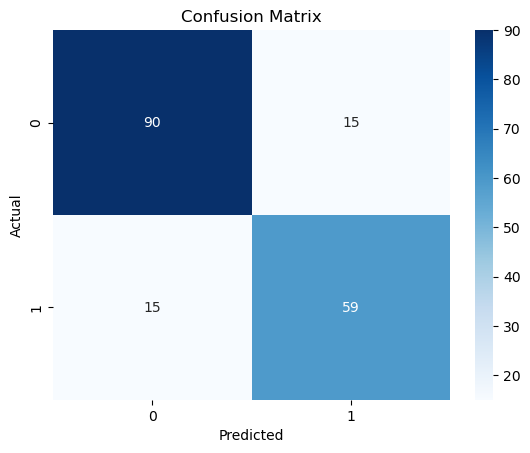

In [68]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix");

## Step 10: Feature Importance Analysis

The bar chart below displays the **top 10 most important features** used by the model, ranked by their contribution to predictions (based on Gini importance or impurity-based importance for tree-based models like Random Forest or XGBoost).

- This helps in understanding **which features the model relies on most**.
- Such insights can be used for **feature selection**, **interpretability**, and even **domain-specific discussions**.

The chart is sorted for clarity, highlighting the strongest contributors at the top.


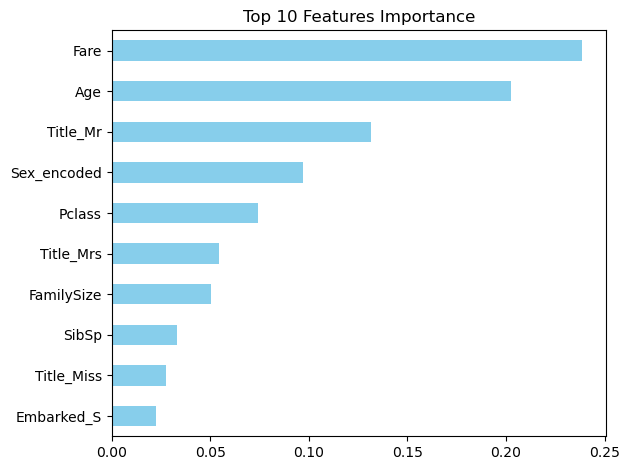

In [69]:
importance = pd.Series(model.feature_importances_, index=X.columns)
importance.nlargest(10).sort_values().plot(kind='barh',color='skyblue')
plt.title('Top 10 Features Importance')
plt.tight_layout()


## Step 11: Hyperparameter Tuning with GridSearchCV

To optimize the performance of our Random Forest model, we perform a **grid search** over a defined set of hyperparameters:

- `n_estimators`: Number of trees in the forest
- `max_depth`: Maximum depth of each tree
- `min_samples_split`: Minimum number of samples required to split an internal node

We use **5-fold cross-validation** and optimize based on the **F1 score**, which balances precision and recall — especially useful for imbalanced datasets.

After training, we use the best estimator found to make predictions and evaluate its performance using the classification report.


In [70]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8, None],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)

# Predict with best model
y_pred_tuned = grid.best_estimator_.predict(X_test)
print("\nTuned Model Report:\n", classification_report(y_test, y_pred_tuned))


Best Parameters: {'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 100}

Tuned Model Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       105
           1       0.81      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



## Step 12: Model Evaluation: Cross-Validation and Accuracy

To validate our model's generalization capability, we perform:

- **5-Fold Cross-Validation** on the training data using **accuracy** as the scoring metric.
- This gives an average performance measure across different training-validation splits and helps reduce the variance of the evaluation.

We also compare:

- **Training Accuracy**: How well the model fits the training data.
- **Test Accuracy**: How well the model performs on unseen data.

This comparison is crucial for diagnosing:
- **Overfitting**: High training accuracy, low test accuracy.
- **Underfitting**: Low accuracy on both sets.


In [71]:
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-Validation Scores:", scores)
print("Average CV Score:", scores.mean())

Cross-Validation Scores: [0.81118881 0.78321678 0.8028169  0.78169014 0.83098592]
Average CV Score: 0.8019797104304146


In [72]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print("Training Accuracy:", train_score)
print("Test Accuracy:", test_score)

Training Accuracy: 0.9831460674157303
Test Accuracy: 0.8324022346368715


## Step 13: Differnet types of Models
We compare the performance of multiple classification algorithms using **5-Fold Cross-Validation** on the training set:

- **Logistic Regression**
- **Support Vector Machine (SVM)**
- **Random Forest**

Each model is evaluated using **accuracy** as the scoring metric. For each model, we report:

- The **mean cross-validation accuracy**
- The individual **scores from each fold**

This approach helps in identifying which model generalizes best across different subsets of the training data and is more robust for deployment or further tuning.


In [73]:
# Create models
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

log_model_pred = log_model.predict(X_test)

In [74]:
print("Classification Report : ", classification_report(y_test,log_model_pred))
print("\nConfusion Report :\n", confusion_matrix(y_test,log_model_pred))

Classification Report :                precision    recall  f1-score   support

           0       0.84      0.85      0.84       105
           1       0.78      0.77      0.78        74

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179


Confusion Report :
 [[89 16]
 [17 57]]


In [75]:
coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_model.coef_[0]
})
coeff_df.sort_values(by='Coefficient', ascending=False)


,Feature,Coefficient
12,Title_Mrs,0.807214
16,AgeGroup_Senior,0.038927
4,Fare,0.004318
1,Age,-0.028100
8,Embarked_Q,-0.110818
3,Parch,-0.145202
2,SibSp,-0.232679
6,IsAlone,-0.277451
5,FamilySize,-0.314667
10,Title_Miss,-0.367963


In [76]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_model_pred = rf_model.predict(X_test)

In [77]:
print("Classification Report : ", classification_report(y_test,rf_model_pred))
print("\nConfusion Report :\n", confusion_matrix(y_test,rf_model_pred))

Classification Report :                precision    recall  f1-score   support

           0       0.86      0.86      0.86       105
           1       0.80      0.80      0.80        74

    accuracy                           0.83       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.83      0.83      0.83       179


Confusion Report :
 [[90 15]
 [15 59]]


In [78]:
SVM_model = SVC(random_state=42)
SVM_model.fit(X_train, y_train)
SVM_model_pred = SVM_model.predict(X_test)

## Step 13: Training a Support Vector Machine (SVM) Model

We train a **Support Vector Machine (SVM)** classifier with a **linear kernel**:

- SVMs are powerful models for both linear and non-linear classification tasks.
- The linear kernel is suitable when the data is approximately linearly separable.
- Other kernels like `'rbf'`, `'poly'`, and `'sigmoid'` can be tried for capturing more complex patterns.

This step fits the model on the training data.


In [79]:
svm_model = SVC(kernel='linear')  # You can also try 'rbf', 'poly', etc.
svm_model.fit(X_train, y_train)


SVC(kernel='linear')

In [80]:
y_pred_svm = svm_model.predict(X_test)

In [81]:
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

[[91 14]
 [18 56]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.76      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



In [82]:
scores = cross_val_score(svm_model, X_train, y_train, cv=5)
print("SVM CV Accuracy:", scores.mean())

SVM CV Accuracy: 0.824386880724909


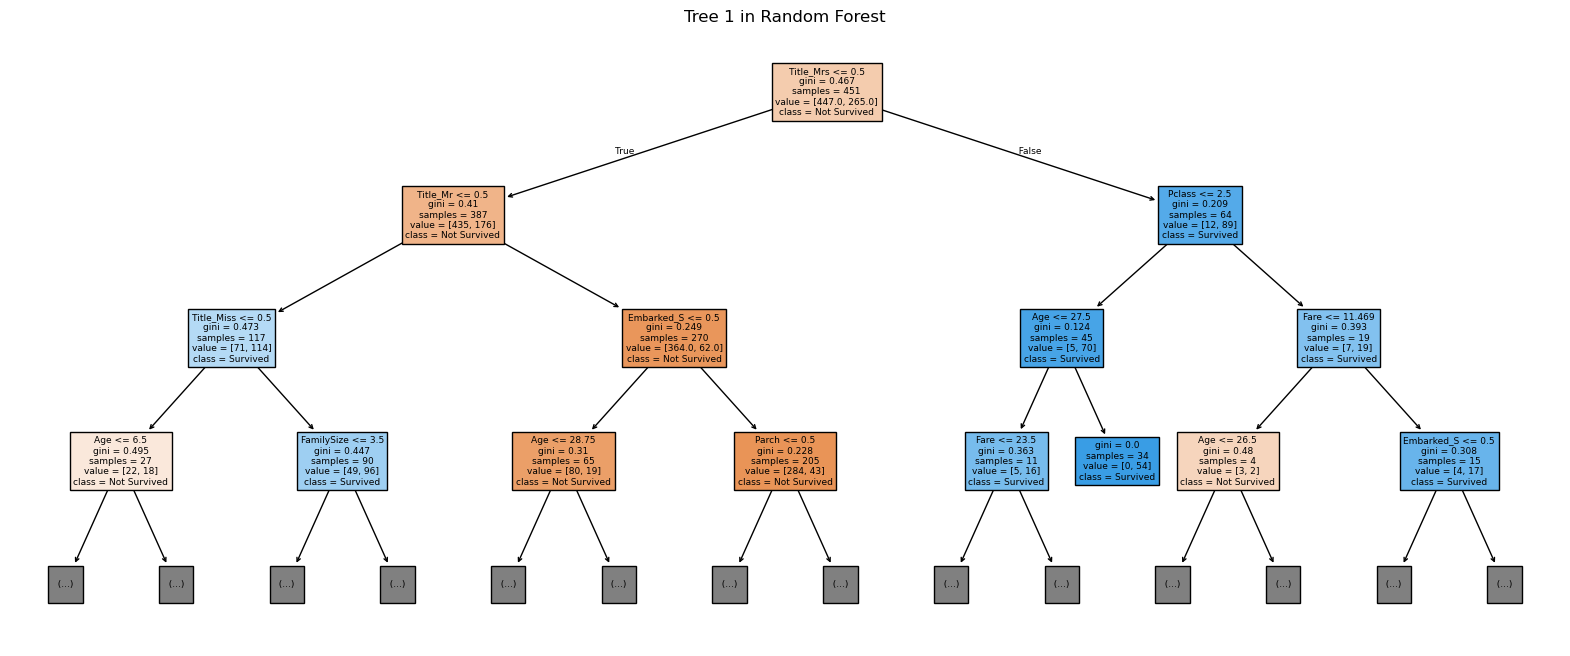

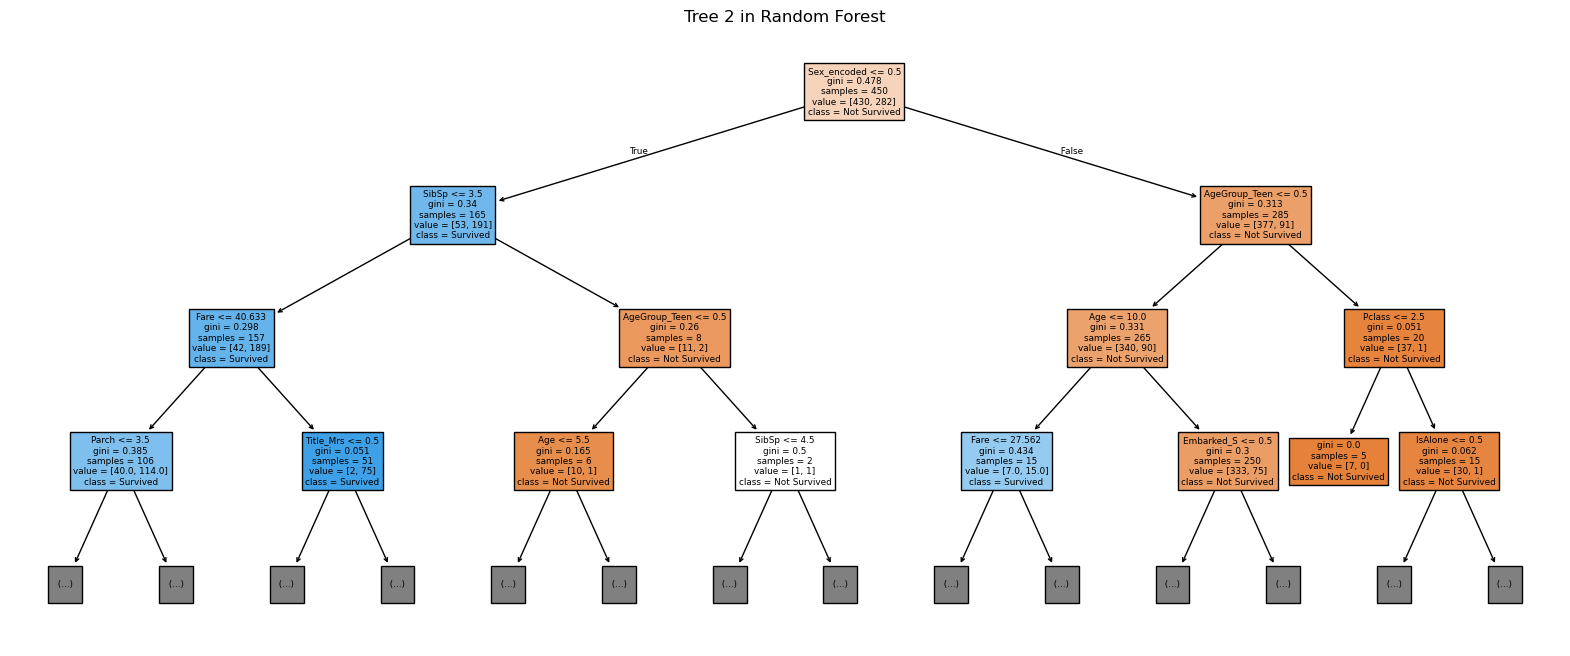

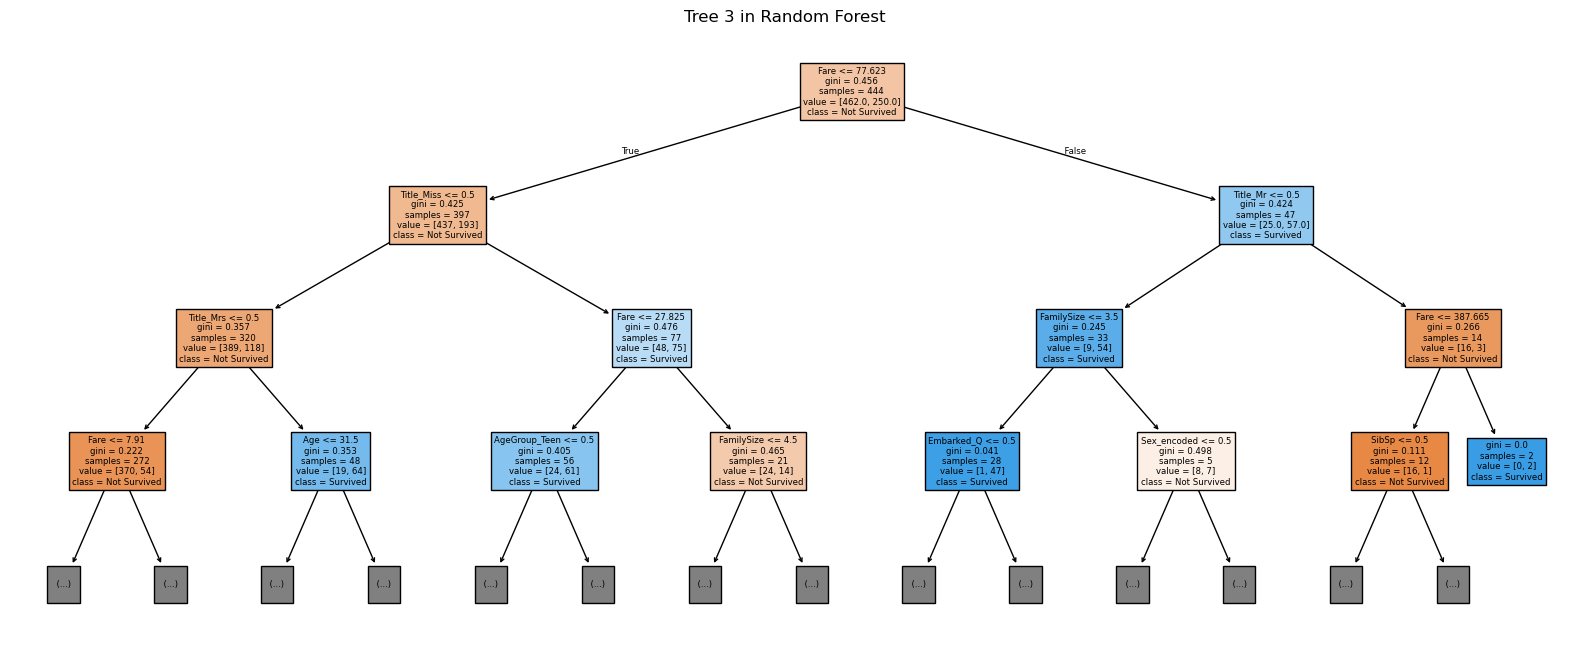

In [83]:
n_trees_to_plot = 3
for i in range(n_trees_to_plot):
    plt.figure(figsize=(20, 8))
    plot_tree(
        grid.best_estimator_.estimators_[i],
        filled=True,
        feature_names=X.columns,
        class_names=["Not Survived", "Survived"],
        max_depth=3  # Optional: Limit depth for readability
    )
    plt.title(f"Tree {i + 1} in Random Forest")

##  Step 14: Train & Evaluate XGBoost Classifier

- **XGBoost** is a powerful boosting algorithm that builds decision trees sequentially to correct errors from previous trees.
- It's well-known for:
  - Fast execution
  - High performance on structured/tabular data
  - Built-in regularization to prevent overfitting
- We trained the model using 100 trees (`n_estimators=100`) and a moderate depth (`max_depth=4`).
- Final evaluation was done on the test set using F1-score, precision, and recall.

 Feature importance is visualized to understand which variables contributed most to survival prediction.


In [84]:
# %pip install xgboost

In [85]:
import xgboost as xgb
from xgboost import XGBClassifier

In [86]:
# ⚡ Train XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)


p:\ANACONDA\envs\ml_env\lib\site-packages\xgboost\training.py:183: UserWarning: [21:47:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [87]:
y_pred_xgb = xgb_model.predict(X_test)

print("📋 XGBoost Classification Report:\n")
print(classification_report(y_test, y_pred_xgb))

📋 XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       105
           1       0.82      0.76      0.79        74

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



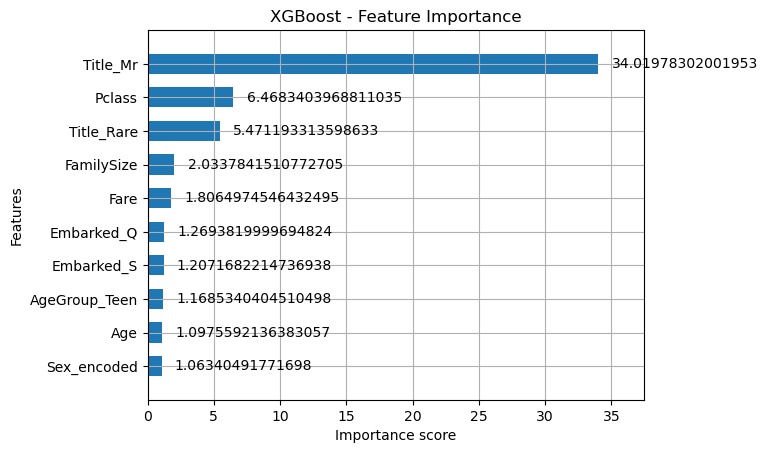

In [88]:
xgb.plot_importance(xgb_model, height=0.6, max_num_features=10, importance_type='gain', title='XGBoost - Feature Importance')
plt.show()

## Step 15: Final Model Evaluation & Comparison

We evaluated four classification models:

- **Logistic Regression**
- **Random Forest**
- **Support Vector Machine (SVM)**
- **XGBoost Classifier**

Each model was assessed based on:
- **Accuracy**: Overall correctness
- **Precision**: Correct positive predictions
- **Recall**: Capturing all actual positives
- **F1-Score**: Balance between precision and recall

A bar chart visualization is included to clearly compare performance.  
The model with the highest F1-score is selected as the best for this dataset.


In [89]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
}

In [90]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    })

p:\ANACONDA\envs\ml_env\lib\site-packages\xgboost\training.py:183: UserWarning: [21:47:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [91]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='F1 Score', ascending=False)
print(df_results)


                    Model  Accuracy  Precision    Recall  F1 Score
2           Random Forest  0.832402   0.797297  0.797297  0.797297
3                 XGBoost  0.832402   0.797297  0.797297  0.797297
0     Logistic Regression  0.815642   0.780822  0.770270  0.775510
1  Support Vector Machine  0.664804   0.769231  0.270270  0.400000


C:\Users\chour\AppData\Local\Temp\ipykernel_7244\1238566669.py:8: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
p:\ANACONDA\envs\ml_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


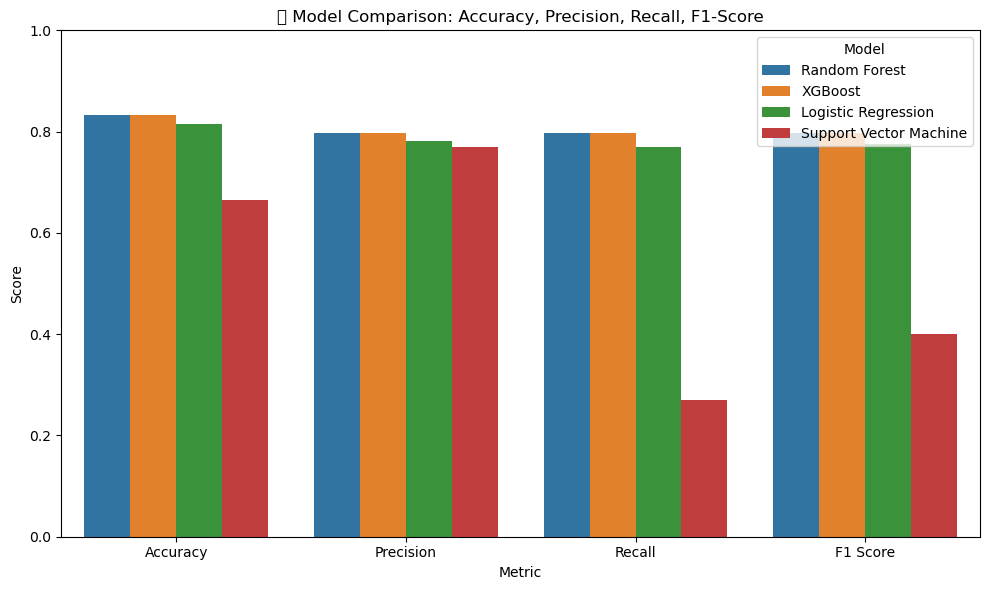

In [92]:
df_melted = df_results.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model')
plt.title("🔍 Model Comparison: Accuracy, Precision, Recall, F1-Score")
plt.ylim(0, 1)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

##  Step 16: Saving the Final Model

The best-performing model (XGBoost) is saved using the `joblib` library, which is ideal for scikit-learn and XGBoost objects.

This allows us to:
- Reload the model later without retraining
- Use it in deployment apps (e.g., Flask, Streamlit)
- Share the model with others or use in APIs

To load the model, use `joblib.load('model_filename.pkl')` and call `.predict()` as usual.


In [93]:
import joblib

best_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss",random_state=42)
best_model.fit(X_train, y_train)

joblib.dump(best_model, 'titanic_best_model_xgboost.pkl')
print("✅ Model saved as 'titanic_best_model_xgboost.pkl")

✅ Model saved as 'titanic_best_model_xgboost.pkl


p:\ANACONDA\envs\ml_env\lib\site-packages\xgboost\training.py:183: UserWarning: [21:47:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [94]:
# 📂 Load the saved model
loaded_model = joblib.load("titanic_best_model_xgboost.pkl")

# 🔍 Predict using the loaded model
predictions = loaded_model.predict(X_test)